In [644]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from cvxopt import matrix
from cvxopt.blas import dot 
from cvxopt import solvers
solvers.options['show_progress'] = False



def load_json(path):
    with open(path, 'rb') as f:
        json_dict = json.load(f)
    return json_dict


def find_first_800(sp_data_matrix, num):
    posts = []
    trading_days = sp_data_matrix.shape[0]
    for i in range(trading_days):
        num_eff = np.sum(sp_data_matrix[i, 2:]>-5)
        if num_eff == num:
            posts.append(i)
    return posts[0]


def get_sub_mat(df_return, st_idx, code_shares, sp_data):
    num_lim = 1260 + 21
    ed_idx = st_idx + num_lim
    code_ls = list(df_return.columns)[1:]
    code_used = []
    res_mat = []
    res_dict = {}
    res_pre_dict = {}
    market_cap_dict = {}
    for code_i in code_ls:
        res = df_return[code_i][st_idx:ed_idx]
        eff_num = np.sum(res>-5)
        if eff_num == num_lim:
            cap_i = code_shares[code_i] * sp_data[code_i][st_idx+1260]
            res_ls  = list(res)
            res_mat.append(res_ls[0:1260])
            code_used.append(code_i)
            res_dict[code_i] = res_ls[0:1260]
            res_pre_dict[code_i] = res_ls[1260:1281]
            market_cap_dict[code_i] = cap_i
    return res_mat, code_used, res_dict, res_pre_dict, market_cap_dict


def get_N(res_mat, code_used, res_dict, res_pre_dict, market_cap_dict, N):
    line_num, row_num = np.where(np.corrcoef(np.array(res_mat))>0.95)
    line_num = line_num.tolist()
    row_num = row_num.tolist()
    for i in range(len(line_num)):
        if  i > j:
            stock_i = code_used[line_num[i]]
            stock_j = code_used[row_num[i]]
            cap_i = market_cap_dict[stock_i]
            cap_j = market_cap_dict[stock_j]
            
            if  cap_i>cap_j:
                code_used.remove(stock_j)
            else:
                code_used.remove(stock_i)
    
    code_cap = {}   
    for code_i in code_used:
        code_cap[code_i] =  market_cap_dict[code_i]
        
    code_cap_sorted = sorted(code_cap.items(), key=lambda x: x[1], reverse=True)
    code_N = [i[0] for i in code_cap_sorted[0:N]]
    
    res_mat_new = []
    res_pre_new = []
    for code_i in code_N:
        res_mat_new.append(res_dict[code_i])
        res_pre_new.append(res_pre_dict[code_i])
    return res_mat_new, res_pre_new


def get_return(weights, res_pre):
    weights = np.matrix(weights)
    res_pre = np.matrix(res_pre)
    return (weights*res_pre).tolist()[0]
    

def average_weights(n):
    return np.matrix([1/n for i in range(n)])


def sample_cov_weights(res_mat):
    cov = np.cov(np.array(res_mat))
    N = cov.shape[0]
    P = matrix(cov)
    q = matrix(np.zeros((N, 1)))
    G  = matrix(-np.identity(N))
    h = matrix(np.zeros((N, 1)))
    A = matrix(1.0, (1, N))
    b = matrix(1.0)
    sol = solvers.qp(P, q, G, h, A, b)
    ws = np.matrix(sol['x']).T
    return ws



def get_returns(code_shares, sp_data, df_return, last_num, N, num):
    st_id = find_first_800(df_return.to_numpy(), num)
    res_ew = []
    res_sample_cov = []
    while st_id + 1281 < last_num:
        res_mat, code_used, res_dict, res_pre_dict, market_cap_dict = get_sub_mat(df_return,
                                                                st_id, code_shares, sp_data)
        res_mat_new, res_pre_new = get_N(res_mat, code_used, 
                               res_dict, res_pre_dict, market_cap_dict, N)
        st_id += 21
        avg_ws = average_weights(N)
        avg_res_i = get_return(avg_ws, res_pre_new)
        res_ew += avg_res_i
        samp_ws = sample_cov_weights(res_mat_new)
        sam_res_i = get_return(samp_ws,  res_pre_new)
        res_sample_cov += sam_res_i
    return res_ew, res_sample_cov

# 1 load_data and get return rates

In [455]:
code_shares = load_json('./code_shares.json')
sp_data = pd.read_csv('./SP1273_19750103_20201231.csv')
df_return = pd.read_csv('./returns127.csv')

In [221]:
j = 0
x = None
codes = []
return_mat = np.zeros((11602, 1271))
j = 0
for i in code_shares:
    price_matrix= sp_data[i].astype('float')
    price_matrix = np.array(price_matrix)
    returns = np.log(price_matrix[1:]) - np.log(price_matrix[0:-1])
    if np.where(returns<-5)[0].shape[0] == 0:
        codes.append(i)
        returns[np.isnan(returns)]=-5
        return_mat[:, j] = returns
        j += 1
df_return = pd.DataFrame(data=return_mat, columns=codes)
df_return.to_csv('returns127.csv')

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in less
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


# 2 get portfolio universe

In [662]:
avg_res, samp_res = get_returns(code_shares, sp_data, df_return, 11602, 500, 800)

In [663]:
AV_avg = np.mean(avg_res)*252*100
AV_sam = np.mean(samp_res)*252*100
SD_avg = np.cov(avg_res)**0.5*252**0.5*100
SD_sam = np.cov(samp_res)**0.5*252**0.5*100
IR_avg = AV_avg/SD_avg
IR_sam = AV_sam/SD_sam

print('|', round(AV_avg, 4), '|', round(SD_avg, 4), '|' , round(IR_avg, 4), '|')
print('|', round(AV_sam, 4), '|', round(SD_sam, 4), '|' , round(IR_sam, 4), '|')

| 6.8272 | 21.9555 | 0.311 |
| 5.6747 | 13.0984 | 0.4332 |


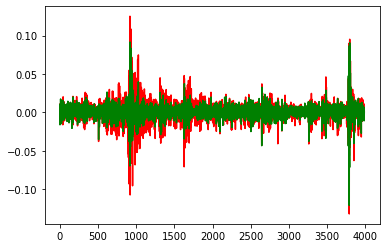

In [654]:
plt.plot(avg_res, c='r')
plt.plot(samp_res, c='g')
plt.show()

In [530]:
AV_avg = np.mean(avg_res[0:2000])*252*100
AV_sam = np.mean(samp_res[0:2000])*252*100
SD_avg = np.cov(avg_res[0:2000])**0.5*252**0.5*100
SD_sam = np.cov(samp_res[0:2000])**0.5*252*0.5*100
IR_avg = AV_avg/SD_avg
IR_sam = AV_sam/SD_sam
print(AV_avg, SD_avg, IR_avg)
print(AV_sam, SD_sam, IR_sam)

4.279581230262239 24.97542596729552 0.17135168128328246
5.260049490471765 75.1875877958109 0.0699590137770696


In [641]:
from cvxopt import matrix
from cvxopt.blas import dot 
from cvxopt.solvers import qp, options 
P = matrix(np.cov(np.random.rand(3,3)))
q = matrix(np.zeros((3, 1)))
G  = matrix(-np.identity(3))
h = matrix(np.zeros((3, 1)))
A = matrix(1.0, (1, 3))
b = matrix(1.0)
sol = qp(P, q, G, h, A, b)
ws = np.matrix(sol['x']).T

     pcost       dcost       gap    pres   dres
 0:  2.1817e-02 -1.0010e+00  1e+00  1e-16  2e+00
 1:  2.1291e-02 -9.9968e-03  3e-02  1e-16  7e-02
 2:  1.1988e-02  7.8862e-03  4e-03  2e-16  2e-17
 3:  1.0703e-02  1.0634e-02  7e-05  2e-16  8e-18
 4:  1.0669e-02  1.0668e-02  7e-07  2e-16  8e-18
 5:  1.0669e-02  1.0669e-02  7e-09  8e-22  8e-18
Optimal solution found.


In [639]:
import cvxopt
print(cvxopt.__file__)


/usr/local/lib/python3.7/site-packages/cvxopt/__init__.py


In [628]:
np.sum(np.array(sol['x']))

1.0

matrix([[-0.1],
        [ 0. ],
        [ 0. ],
        [ 0. ]])